This notebook aims to explore the library [`cython`](https://cython.readthedocs.io/en/latest/index.html) and its capabilities while also benchmarking the performance difference

> Author: Asif Sayyed
> Requirements: setuptools, cython

# Test 1: Pi Calculation

In [16]:
import cython
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from src.test_helper import run_benchmark, format_value, format_time

%load_ext Cython
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 250

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [3]:
def calculate_pi_python(n_terms: int) -> float:
    numerator = 4.0
    denominator = 1.0
    sign = 1.0
    pi = 0.0

    for _ in range(n_terms):
        pi += sign * (numerator / denominator)
        denominator += 2.0
        sign *= -1.0
    return pi

In [4]:
%%cython

def calculate_pi_cython(int n_terms):
    """
    Optimized Cython version of the Pi calculation function.
    """
    cdef double numerator = 4.0
    cdef double denominator = 1.0
    cdef double sign = 1.0
    cdef double pi = 0.0
    # declare the loop variable
    cdef int i

    # the nogil context manager can give more speed in specific cases
    # but for simple loops, static typing is the main benefit
    for i in range(n_terms):
        pi += sign * (numerator / denominator)
        denominator += 2.0
        sign *= -1.0
    return pi

In [5]:
functions_to_compare = {
    "Python": calculate_pi_python,
    "Cython": calculate_pi_cython,
}

# increasing the input size at log scale to see performance over different scales
input_sizes = [1_000, 10_000, 100_000, 1_000_000, 5_000_000, 10_000_000]

In [6]:
benchmark_results = run_benchmark(functions_to_compare, input_sizes, num_runs=5)

Running benchmarks...
  Testing Python...
  Testing Cython...
Finished.


In [36]:
benchmark_results

,terms,version,time (s)
0,1000,Python,0.000123
1,10000,Python,0.000918
2,100000,Python,0.009552
3,1000000,Python,0.095297
4,5000000,Python,0.414698
5,10000000,Python,0.828440
6,1000,Cython,0.000002
7,10000,Cython,0.000013
8,100000,Cython,0.000129
9,1000000,Cython,0.001223


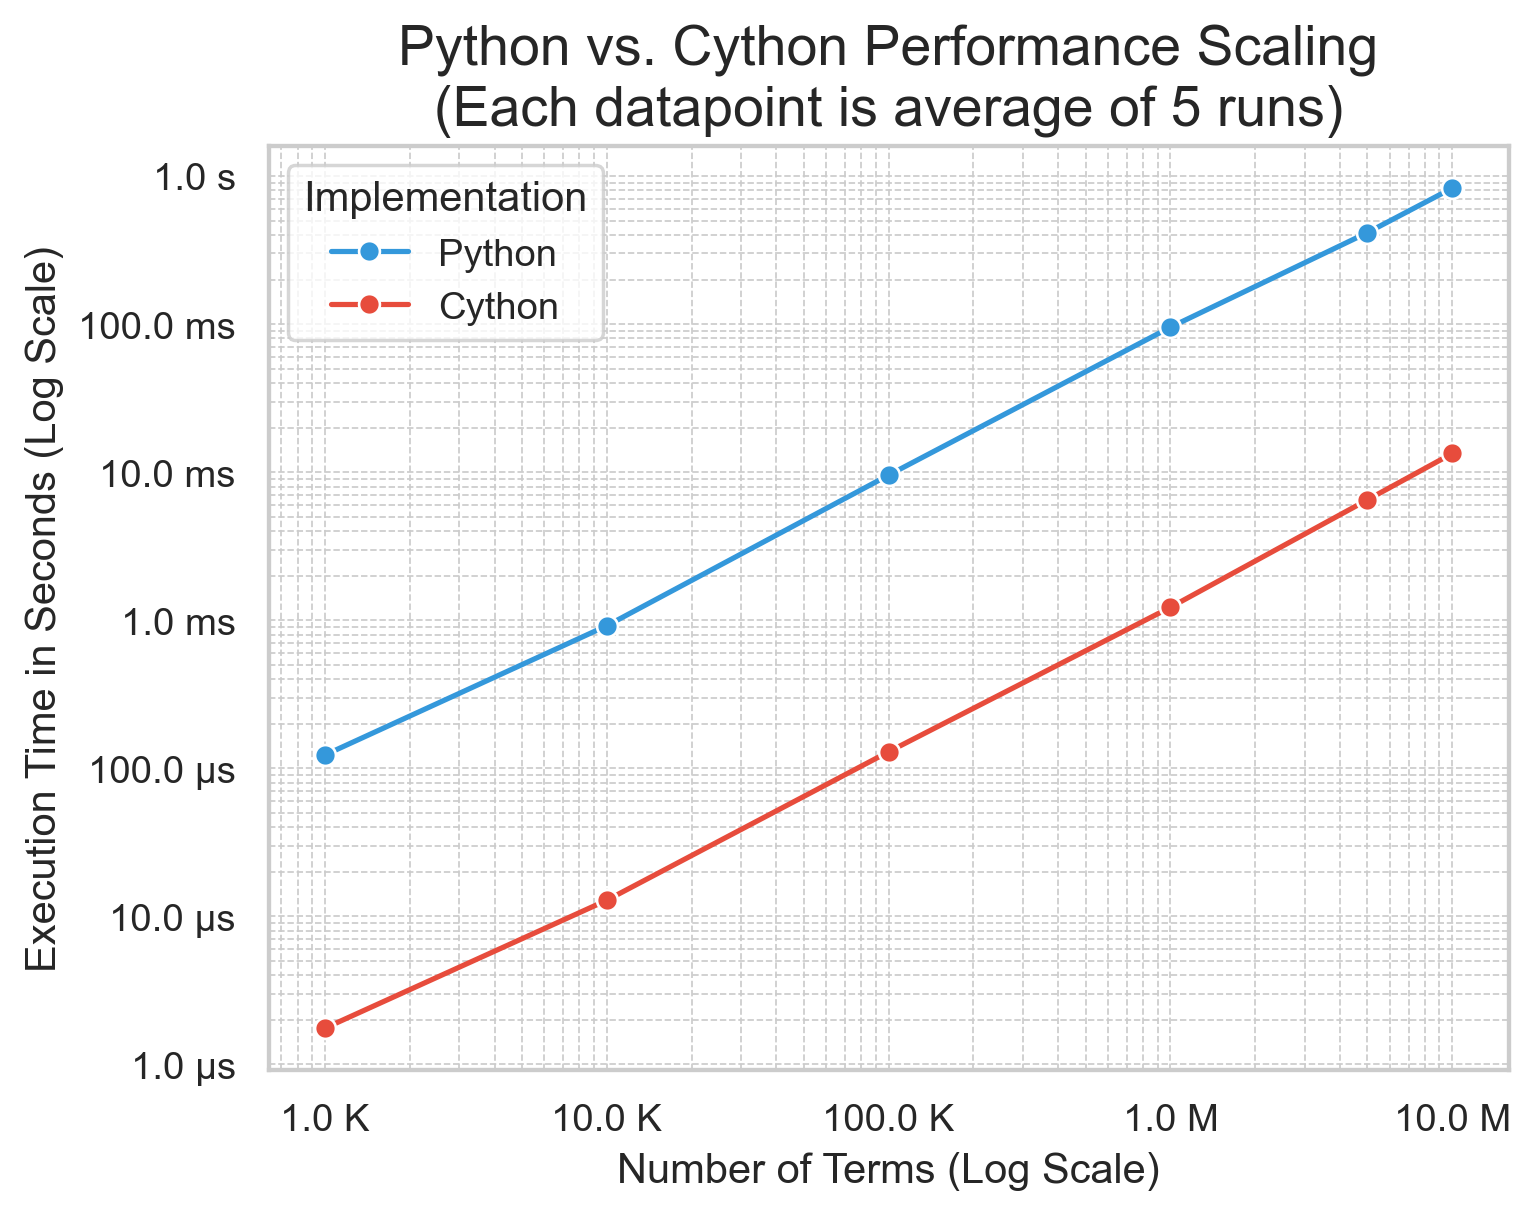

In [22]:
plot = sns.lineplot(
    data=benchmark_results,
    x='terms',
    y='time (s)',
    hue='version',
    marker='o',
    palette=['#3498db', '#e74c3c'],
)
plt.yscale('log')
plt.xscale('log')
plt.title('Python vs. Cython Performance Scaling\n(Each datapoint is average of 5 runs)', fontsize=16)
plt.xlabel('Number of Terms (Log Scale)', fontsize=12)
plt.ylabel('Execution Time in Seconds (Log Scale)', fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_value))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_time))

plt.legend(title='Implementation')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Test 2: NumPy GrayScale Image Conversion

In [14]:
def to_grayscale_python(image: np.ndarray) -> np.ndarray:
    """
    Convert an RGB image to grayscale using Python.
    """
    img = image.astype(np.float64)
    height, width, _ = img.shape
    gray_image = np.zeros((height, width), dtype=np.float64)

    for h in range(height):
        for w in range(width):
            gray_image[h, w] = 0.21 * img[h, w, 0] + 0.72 * img[h, w, 1] + 0.07 * img[h, w, 2]

    return gray_image

In [ ]:
%%cython
import numpy as np
# cimport is like a C-level import
cimport numpy as np

# The @cython.boundscheck(False) and @cython.wraparound(False) decorators
# turn off some of Python's safety checks for a speed boost. Use with care!
import cython
@cython.boundscheck(False)
@cython.wraparound(False)
def to_grayscale_cython(double[:, :, :] image):
    """Cython version using typed memoryviews for fast array access."""
    cdef int h = image.shape[0]
    cdef int w = image.shape[1]

    # Create the output array
    cdef double[:, :] gray_img = np.zeros((h, w), dtype=np.float64)

    cdef int i, j
    for i in range(h):
        for j in range(w):
            gray_img[i, j] = 0.21 * image[i, j, 0] + 0.72 * image[i, j, 1] + 0.07 * image[i, j, 2]

    return np.asarray(gray_img, dtype=np.uint8)

Content of stdout:
_cython_magic_0a33f232eaefdd3f3bda3cc7afcb3aa062dc134f04fb10983ec6b3a4bc8ad982.c
C:\Users\sayye\.ipython\cython\_cython_magic_0a33f232eaefdd3f3bda3cc7afcb3aa062dc134f04fb10983ec6b3a4bc8ad982.c(19019): warning C4244: '=': conversion from 'Py_ssize_t' to 'int', possible loss of data
C:\Users\sayye\.ipython\cython\_cython_magic_0a33f232eaefdd3f3bda3cc7afcb3aa062dc134f04fb10983ec6b3a4bc8ad982.c(19028): warning C4244: '=': conversion from 'Py_ssize_t' to 'int', possible loss of data
   Creating library C:\Users\sayye\.ipython\cython\Users\sayye\.ipython\cython\_cython_magic_0a33f232eaefdd3f3bda3cc7afcb3aa062dc134f04fb10983ec6b3a4bc8ad982.cp313-win_amd64.lib and object C:\Users\sayye\.ipython\cython\Users\sayye\.ipython\cython\_cython_magic_0a33f232eaefdd3f3bda3cc7afcb3aa062dc134f04fb10983ec6b3a4bc8ad982.cp313-win_amd64.exp
Generating code
Finished generating code

In [34]:
import timeit
import pandas as pd
import numpy as np

image_sizes = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
num_runs = 5

functions_to_compare = {
    'Python': to_grayscale_python,
    'Cython': lambda img: to_grayscale_cython(img.astype(np.float64))
}

grayscale_results_list = []

print("Running grayscale benchmark...")

for name, func in functions_to_compare.items():
    print(f"  Testing {name}...")
    for size in image_sizes:
        np.random.seed(432)
        image_data = np.random.randint(0, 256, size=(size, size, 3), dtype=np.uint8)

        timer = timeit.Timer(lambda: func(image_data))
        total_time = timer.timeit(number=num_runs)
        avg_time = total_time / num_runs

        grayscale_results_list.append({
            'Image Size (pixels)': size * size,
            'Dimensions': f'{size}x{size}',
            'Version': name,
            'Time (s)': avg_time
        })

print("Finished.")

grayscale_results_df = pd.DataFrame(grayscale_results_list)
display(grayscale_results_df)

Running grayscale benchmark...
  Testing Python...
  Testing Cython...
Finished.


,Image Size (pixels),Dimensions,Version,Time (s)
0,10000,100x100,Python,0.006402
1,62500,250x250,Python,0.041745
2,250000,500x500,Python,0.183045
3,1000000,1000x1000,Python,0.625978
4,2250000,1500x1500,Python,1.430013
5,4000000,2000x2000,Python,2.578121
6,6250000,2500x2500,Python,3.949412
7,9000000,3000x3000,Python,5.705646
8,12250000,3500x3500,Python,7.688148
9,16000000,4000x4000,Python,10.162169


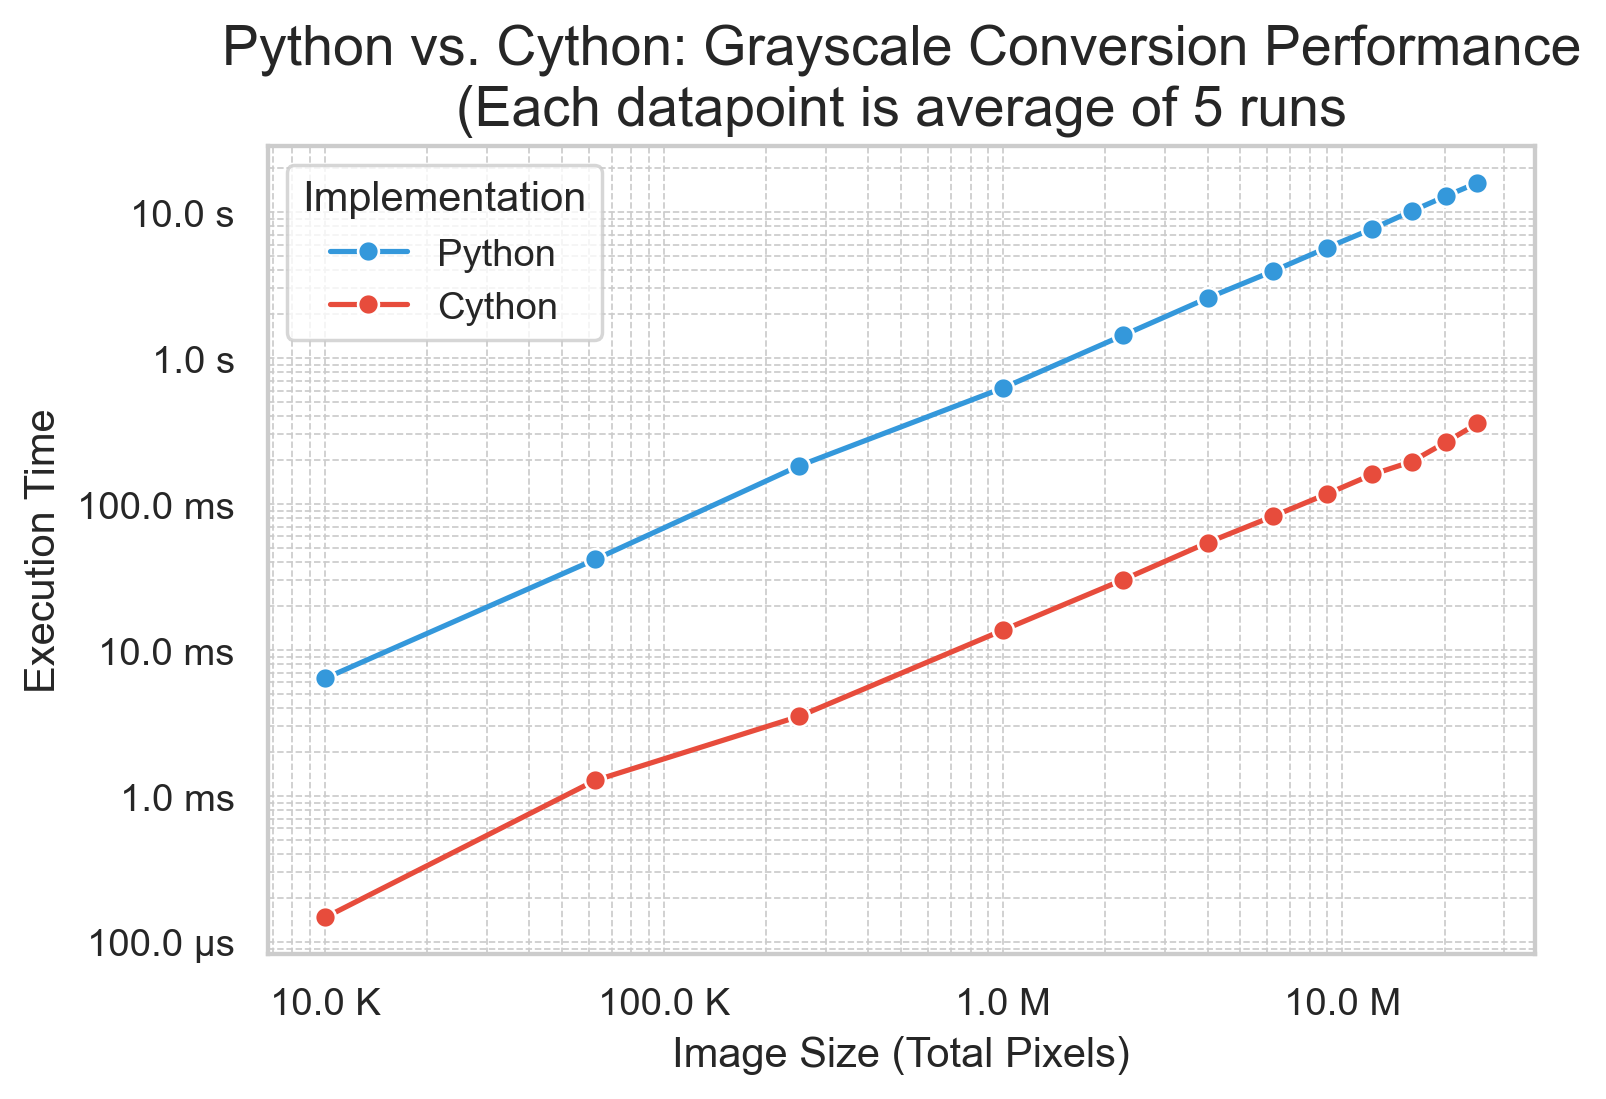

In [35]:
sns.lineplot(
    data=grayscale_results_df,
    x='Image Size (pixels)',
    y='Time (s)',
    hue='Version',
    marker='o',
    palette=['#3498db', '#e74c3c']
)
plt.yscale('log')
plt.xscale('log')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_value))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_time))
plt.title('Python vs. Cython: Grayscale Conversion Performance\n(Each datapoint is average of 5 runs', fontsize=16)
plt.xlabel('Image Size (Total Pixels)', fontsize=12)
plt.ylabel('Execution Time', fontsize=12)
plt.legend(title='Implementation')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()